In [38]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import clear_output
import time
plt.rcParams.update({'font.size': 14})

from utilities import error, prepare_phi_and_S, convert1D_to_2D, plot_phi,residual

In [39]:
def prepare_phi_and_S(Nx,phi,C):

    # Generate RHS source terms matrix and unknowns 'phi' with Dirichlet BCs
    S = np.zeros((Nx))

    # RHS source terms
    for i in range(Nx):
        source = np.exp(C*phi[i])
        S[i] = source


    ## Right BC
    i = Nx-1 
    phiR = 1
    phi[i] = phiR
    S[i] = phiR
        
    ## left BC
    i = 0   
    phiL = 0
    phi[i] = phiL
    S[i] = phiL 

    return phi, S

In [40]:
def TRI(N,a,d,c,Q):
    '''
    ┌                                        ┐
    │  d1  c1  0 ...                        0│
    │  a1  d2  c2  0 ...                    0│
    │        .                               │
    │          .                             │
    │            .                           │┌     ┐  ┌     ┐
    │... 0   ai-2  di-1  ci-1 0  ...         ││Phi_x│= | Q_x |
    │                  .                     │└     ┘  └     ┘
    │                   .                    │
    │                    .                   │
    │0     ... 0   aN-2  dN-1  cN-1  0  ...  │
    │0         ... 0   aN-1  dN    0  ...    │ 
    └                                        ┘
    '''
    # Tridiagonal matrix solver
    phi = np.zeros(N)

    # Forward Elemination
    for i in range (1,N):
        const = a[i-1] / d[i-1]
        d[i] = d[i] - const*c[i-1] # Diagonal
        Q[i] = Q[i] - const*Q[i-1]  # RHS
    
    # Solve last equation 
    phi[-1] = Q[-1]/d[-1]

    # Qackward Elemination
    for i in range(N-2,-1,-1):
        
        phi[i] = (Q[i] - c[i]*phi[i+1]) / d[i]

    return phi

In [57]:
# numbering scheme used is k = (j-1)*N + i
start = time.time()
Nx = 41

L = 1  # length
M = np.zeros(Nx)  # an empty matrix
phi = np.zeros(Nx)
S = np.zeros(Nx)

dx = L / (Nx - 1)  # Grid size

tol = 1e-10

aE = 1 / dx ** 2
aW = 1 / dx ** 2
a0 = -(2 / dx ** 2)

C = 2
phi, S = prepare_phi_and_S(Nx, phi, C)

for _ in tqdm(range(100000)):

    c = np.zeros(Nx - 1)
    a = np.zeros(Nx - 1)
    d = np.zeros(Nx)
    Q = np.zeros(Nx)

    # For Dirichlet BC
    d[0] = 1

    # Left BC
    Q[0] = phi[0]

    for i in range(1, Nx - 1):
        # Coefficient for Tridiagonal matrix solver
        d[i] = a0
        a[i - 1] = aW
        c[i] = aE

        # RHS for Tri matrix
        S[i] = np.exp(C * phi[i])
        Q[i] = S[i]

        # For Dirichlet BC
    d[Nx - 1] = 1

    # Right BC
    Q[Nx - 1] = phi[-1]

    # Solve for current row
    phix = TRI(Nx, a, d, c, Q)

    # Update current new row solution
    phi[:] = phix

    # Calculate residual
    R2 = 0
    R = np.zeros(Nx)

    for i in range(1, Nx - 1):
        R[i] = S[i] - aE * phi[i + 1] - aW * phi[i - 1] - a0 * phi[i]
        R2 = R2 + R[i] ** 2

    R2 = np.sqrt(R2)
    if _ % 200 == 0:
        clear_output(True)
        print("Residual: ", R2)

    if R2 < tol:
        print('At :', _, 'Converged! Residual: ', R2, 'Time elapsed: ', time.time() - start)
        break

  0%|          | 0/100000 [00:00<?, ?it/s]

Residual:  1.0361262714899445e-12
At : 0 Converged! Residual:  1.0361262714899445e-12 Time elapsed:  0.0034170150756835938


In [56]:
N=41    # Number of grid points
L = 1   # length
M = np.zeros((N,N)) # an empty matrix
S = np.zeros(N)
phi = np.zeros(N)
dx = L/(N-1)    # Grid size

# Left BCs
M[0,0]=1
S[0] = 0

# Right BCs
M[N-1,N-1] = 1
S[-1] = 1
for _ in tqdm(range(100000)):

    # Construct Sparse Matrix
    # Interior
    for i in range(1,N-1):
        M[i,i] = -2/(dx**2)
        M[i,i-1] = 1/(dx**2)
        M[i,i+1] = 1/(dx**2)
        
        # Construct RHS matrix
        S[i] = np.exp(2*phi[i])

    # Numerical method
    phi = np.matmul(np.linalg.inv(M),S)

    R = np.linalg.inv(M)@S
    for i in range(1, Nx - 1):
        R2 = R2 + R[i] ** 2

    R2 = np.sqrt(R2)
    if _ % 200 == 0:
        clear_output(True)
        print("Residual: ", R2)

    if R2 < tol:
        print('At :', _, 'Converged! Residual: ', R2, 'Time elapsed: ', time.time() - start)
        break

Residual:  3.201236073245052


  5%|▌         | 5272/100000 [00:01<00:25, 3718.98it/s]


KeyboardInterrupt: 

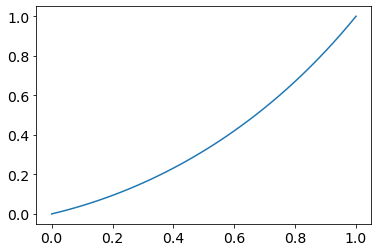

In [55]:
# Analytical solution
x = np.linspace(0,1,Nx)

plt.plot(x,phi)






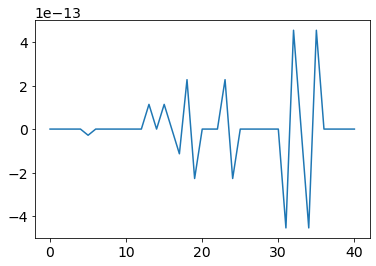

In [43]:
plt.plot(R)